In [62]:
# =============== CÉLULA 1: CONFIGURAÇÕES GERAIS ===============
FITAR_MODELO = True       # True para executar o MCMC, False para só plotar
PLOTAR_GRAFICOS = True    # True para mostrar gráficos após o fit
USAR_PARALELISMO = True   # True para usar todos os núcleos do processador
N_CORES = -1              # -1 para usar todos os núcleos

# Parâmetros para fit (nome: [valor_inicial, mínimo, máximo])
PARAMETROS_FIT = {
    'b0': [1.0, 0.0, 2.0],
    'b1': [0.5, 0.0, 2.0],
    't1': [30, 0, 120],
    'delta': [0.3, 0.0, 1.0],
    'k': [0.2, 1/6, 1/3],
    'h': [0.1, 0.0, 0.5],
    'p': [0.2, 0.0, 1.0],
    'gamma_h': [0.2, 0.0, 1.0],
    'mu_h': [0.1, 0.0, 1.0],
    # Parâmetros de vacinação e correlatos
    'phi': [0.3, 0.0, 1.0],
    'eps': [0.5, 0.0, 1.0],
    'delta_av': [0.2, 0.0, 1.0],
    'delta_sv': [0.2, 0.0, 1.0],
    'gamma_av': [1/3.5, 0.0, 1.0],
    'gamma_sv': [1/4.0, 0.0, 1.0],
    'gamma_hv': [0.2, 0.0, 1.0],
    'mu_hv': [0.05, 0.0, 1.0],
    'k_v': [1/3.0, 0.0, 1.0],
    'p_v': [0.2, 0.0, 1.0],
    'h_v': [0.02, 0.0, 0.5],
    
    'i0': [50, 1, 100]
}
N = 14136417  # População total

# Quais dados usar no fit?
USAR_CASOS = True
USAR_MORTES = True
USAR_HOSP = True

# Configurações do MCMC
NWALKERS = 62     # Número de walkers
NITER = 100       # Iterações por walker
BURNIN = 1000       # Iterações de burn-in

# Caminhos dos arquivos
ARQUIVO_DADOS = "cleanned_data.csv"
SAIDA_PARAMS = "./params_2021.txt"
SAIDA_CONDINI = "./condini_2021.txt"


In [63]:
# =============== IMPORTAÇÕES ===============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from multiprocessing import cpu_count

# Configura o número de cores
if USAR_PARALELISMO:
    if N_CORES == -1:
        N_CORES = cpu_count()
    print(f"Usando {N_CORES} núcleos do processador")
else:
    N_CORES = 1


Usando 16 núcleos do processador


In [64]:
# =============== CÉLULA 3: CARREGAR E PREPROCESSAR DADOS ===============
print("Carregando dados...")
df = pd.read_csv(ARQUIVO_DADOS)

# Função para média móvel
def media_movel(arr, janela=7):
    return np.convolve(arr, np.ones(janela)/janela, mode='valid')

# Converte datas e alinha com média móvel (primeiro valor válido é no índice janela-1)
dates = pd.to_datetime(df['Date']).values
dates_ma = dates[6:]  # alinhado com média móvel de janela 7

# Séries com média móvel
daily_cases = media_movel(df.casos.values)
daily_death = media_movel(df.mortes.values)
daily_hosp = media_movel(df.hospitalizados.values)
daily_vac = media_movel(df.vacinados.values)

# Máscara para 2021 nas datas alinhadas
mask_2021 = (pd.to_datetime(dates_ma).year == 2021)

# Cortes temporais apenas de 2021
daily_cases_1 = daily_cases[mask_2021]
daily_death_1 = daily_death[mask_2021]
daily_hosp_1 = daily_hosp[mask_2021]
daily_vac_1 = daily_vac[mask_2021]

# Versões acumuladas para casar com saídas cumulativas do modelo (C, D, Nh)
cases_cumu_1 = np.cumsum(daily_cases_1)
death_cumu_1 = np.cumsum(daily_death_1)
hosp_cumu_1 = np.cumsum(daily_hosp_1)

# Guarda datas de 2021 (alinhadas)
dates_2021 = pd.to_datetime(dates_ma)[mask_2021].values

print(f"Período 2021: {str(dates_2021[0])} a {str(dates_2021[-1])}, n={len(dates_2021)}")


Carregando dados...
Período 2021: 2021-01-01T00:00:00.000000000 a 2021-12-31T00:00:00.000000000, n=363


In [65]:
# =============== CÉLULA 5 (atualização do modelo com vacinação no fit) ===============
# Reescreve model_2021 e model() para usar todos os parâmetros (incl. _v) do PARAMETROS_FIT

# Ordem esperada dos parâmetros para ODE (exclui apenas i0):
ODE_PARAM_ORDER = (
    'b0','b1','t1',
    'delta','k','h','p','gamma_h','mu_h',
    'phi','eps','delta_av','delta_sv','gamma_av','gamma_sv',
    'gamma_hv','mu_hv','k_v','p_v','h_v'
)


def model_2021(t, y, args):
    (b0, b1, t1,
     delta, k, h, p, gamma_h, mu_h,
     phi, eps, delta_av, delta_sv, gamma_av, gamma_sv,
     gamma_hv, mu_hv, k_v, p_v, h_v) = args

    beta = b0 if t <= t1 else b1

    gamma_s = 1/4
    gamma_a = 1/3.5

    S, E, V, Sv, Ev, Ia, Is, Iav, Isv, H, Hv, R, D, C, Nh, CHv, Cv = y

    # Usa série temporal de vacinação (alinhada) como taxa de entrada
    tau_t = daily_vac_1[int(t)] if int(t) < len(daily_vac_1) else daily_vac_1[-1]

    dSdt = -beta*S*(Is + delta*Ia + delta_av*Iav + delta_sv*Isv)/N - tau_t
    dVdt = tau_t - phi*V
    dEdt = beta*(Is + delta*Ia + delta_av*Iav + delta_sv*Isv)*S/N - k*E
    dSvdt = phi*V - (1-eps)*beta*Sv*(Is + delta*Ia + delta_av*Iav + delta_sv*Isv)/N
    dEvdt = (1-eps)*beta*Sv*(Is + delta*Ia + delta_av*Iav + delta_sv*Isv)/N - k_v*Ev

    dIadt = (1-p)*k*E - gamma_a*Ia
    dIsdt = p*k*E - gamma_s*Is
    dHdt = h*gamma_s*Is - gamma_h*H - mu_h*H

    dIavdt = (1-p_v)*k_v*Ev - gamma_av*Iav
    dIsvdt = p_v*k_v*Ev - gamma_sv*Isv
    dHvdt = h_v*gamma_sv*Isv - gamma_hv*Hv - mu_hv*Hv

    dRdt = gamma_a*Ia + gamma_av*Iav + (1-h)*gamma_s*Is + (1-h_v)*gamma_sv*Isv + gamma_h*H + gamma_hv*Hv
    dDdt = mu_h*H + mu_hv*Hv
    dCdt = p*k*E
    dNHdt = h*gamma_s*Is
    dCHvdt = h_v*gamma_sv*Isv
    dCVdt = p_v*k_v*Ev

    return [dSdt, dEdt, dVdt, dSvdt, dEvdt, dIadt, dIsdt, dIavdt, dIsvdt,
            dHdt, dHvdt, dRdt, dDdt, dCdt, dNHdt, dCHvdt, dCVdt]



In [66]:
def lnprior(theta):
    for i, (key, vals) in enumerate(PARAMETROS_FIT.items()):
        if not (vals[1] <= theta[i] <= vals[2]):
            return -np.inf
    return 0.0


def model(theta):
    # Constrói dict dos parâmetros respeitando a ordem de inserção do dict
    keys = list(PARAMETROS_FIT.keys())
    theta_map = {k: v for k, v in zip(keys, theta)}

    # Separa i0
    i0 = float(theta_map['i0'])

    # Monta tupla de parâmetros para ODE na ordem esperada
    ode_params = tuple(float(theta_map[k]) for k in ODE_PARAM_ORDER)

    sol = solve_ivp(
        model_2021,
        [0, len(daily_cases_1)],
        y0=[N-i0,0,0,0,0,0,i0,0,0,0,0,0,0,i0,0,0,0],
        args=(ode_params,),
        t_eval=np.arange(len(daily_cases_1))
    )
    return sol


def lnlike(theta):
    sol = model(theta)
    y_model = []
    y_data = []
    
    # O modelo retorna cumulativos nas últimas colunas: [-4]=C, [-5]=D, [-3]=Nh
    if USAR_CASOS:
        y_data.extend(cases_cumu_1)
        y_model.extend(sol.y[-4])
    
    if USAR_MORTES:
        y_data.extend(death_cumu_1)
        y_model.extend(sol.y[-5])
    
    if USAR_HOSP:
        y_data.extend(hosp_cumu_1)
        y_model.extend(sol.y[-3])
    
    y_data = np.array(y_data)
    y_model = np.array(y_model)
    
    # Ajusta tamanhos: usa até o min comprimento comum
    n = min(len(y_data), len(y_model))
    y_data = y_data[:n]
    y_model = y_model[:n]
    
    return -0.5 * np.sum(((y_data - y_model)/0.05) ** 2)


def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)


In [67]:
# =============== CÉLULA 6: EXECUÇÃO DO MCMC ===============
if FITAR_MODELO:
    print("Iniciando MCMC com paralelização...")
    
    # Desenha walkers uniformemente dos intervalos de prior para reduzir colinearidade
    keys = list(PARAMETROS_FIT.keys())
    bounds = np.array([PARAMETROS_FIT[k][1:3] for k in keys], dtype=float)
    lows, highs = bounds[:,0], bounds[:,1]
    ndim = len(keys)
    
    # Garante pelo menos 2*ndim walkers e aplica jitter pequeno
    NWALKERS_LOCAL = max(2*ndim, NWALKERS)
    rng = np.random.default_rng()
    base = lows + (highs - lows) * rng.random((NWALKERS_LOCAL, ndim))
    jitter = 1e-3 * (highs - lows) * rng.standard_normal((NWALKERS_LOCAL, ndim))
    p0 = np.clip(base + jitter, lows, highs)
    
    # Configuração do sampler com paralelismo
    from emcee import EnsembleSampler
    from joblib import Parallel, delayed
    
    def evaluate_lnprob(theta):
        return lnprob(theta)
    
    class ParallelPool:
        def __init__(self, n_cores):
            self.n_cores = n_cores
        def map(self, func, tasks):
            return Parallel(n_jobs=self.n_cores)(delayed(func)(task) for task in tasks)
    
    pool = ParallelPool(N_CORES)
    sampler = EnsembleSampler(NWALKERS_LOCAL, ndim, lnprob, pool=pool)
    
    print("Burn-in...")
    pos, prob, state = sampler.run_mcmc(p0, BURNIN)
    sampler.reset()
    
    print("Produção...")
    sampler.run_mcmc(pos, NITER, progress=True)
    
    theta_max = sampler.flatchain[np.argmax(sampler.flatlnprobability)]
    np.savetxt(SAIDA_PARAMS, [theta_max], delimiter=',')


Iniciando MCMC com paralelização...
Burn-in...
Produção...


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


Plotando resultados...


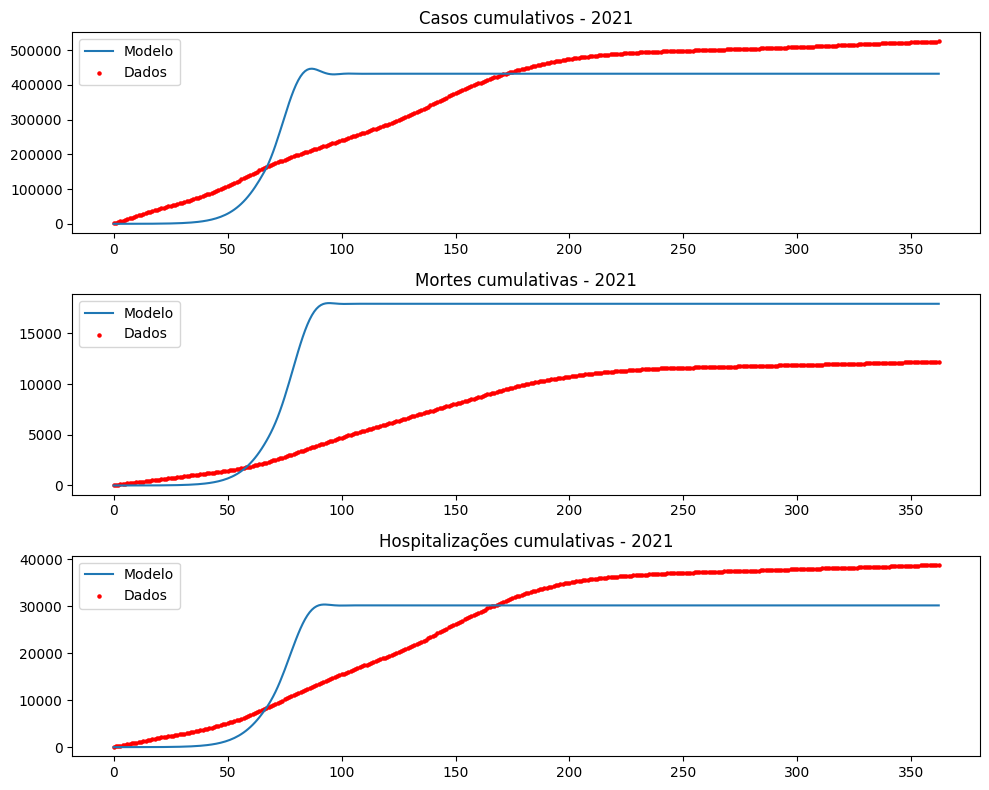

In [68]:
# =============== CÉLULA 7: VISUALIZAÇÃO ===============
if PLOTAR_GRAFICOS:
    print("Plotando resultados...")
    
    # Carrega parâmetros (do fit ou arquivo)
    if FITAR_MODELO:
        theta_plot = theta_max
    else:
        theta_plot = np.loadtxt(SAIDA_PARAMS)
    
    # Roda modelo
    sol = model(theta_plot)
    
    # Plotagem
    fig, axs = plt.subplots(3, 1, figsize=(10, 8))
    
    if USAR_CASOS:
        axs[0].plot(sol.y[-4], label='Modelo')
        axs[0].scatter(np.arange(len(cases_cumu_1)), cases_cumu_1, 
                      s=5, color='red', label='Dados')
        axs[0].set_title('Casos cumulativos - 2021')
    
    if USAR_MORTES:
        axs[1].plot(sol.y[-5], label='Modelo')
        axs[1].scatter(np.arange(len(death_cumu_1)), death_cumu_1, 
                      s=5, color='red', label='Dados')
        axs[1].set_title('Mortes cumulativas - 2021')
    
    if USAR_HOSP:
        axs[2].plot(sol.y[-3], label='Modelo')
        axs[2].scatter(np.arange(len(hosp_cumu_1)), hosp_cumu_1, 
                      s=5, color='red', label='Dados')
        axs[2].set_title('Hospitalizações cumulativas - 2021')
    
    for ax in axs:
        ax.legend()
    plt.tight_layout()
    plt.show()


In [70]:
# =============== CÉLULA 9: SALVAR CONDIÇÕES INICIAIS (condini 2021) ===============
# Gera e salva o vetor de condições iniciais (y0) usado para 2021
import numpy as np

# Obtém theta para montar y0
if FITAR_MODELO:
    theta_save = theta_max
else:
    theta_save = np.loadtxt(SAIDA_PARAMS)

# Constrói dict de parâmetros na mesma ordem do dicionário de fit
keys = list(PARAMETROS_FIT.keys())
theta_map = {k: v for k, v in zip(keys, theta_save)}

# Extrai i0 (demais variáveis de estado iniciais são zero conforme model())
i0 = float(theta_map['i0'])

# Estado inicial (ordem: S, E, V, Sv, Ev, Ia, Is, Iav, Isv, H, Hv, R, D, C, Nh, CHv, Cv)
y0 = np.array([N - i0, 0, 0, 0, 0, 0, i0, 0, 0, 0, 0, 0, 0, i0, 0, 0, 0], dtype=float)

# Salva em arquivo
np.savetxt(SAIDA_CONDINI, y0.reshape(1, -1), delimiter=',')
print(f"Condições iniciais salvas em {SAIDA_CONDINI}")


Condições iniciais salvas em ./condini_2021.txt
